# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [9]:
# Set default figsize to 10 inches by 6 inches
plt.rcParams["figure.figsize"] = (10,6)

# Functions

In [21]:
def plot_series(time,series,format='-',start=0,end=None,label=None):
  plt.plot(time[start:end],series[start:end])
  plt.xlabel("Time")
  plt.ylabel("Value")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

In [3]:
def trend(time,slope=0):
  return time * slope

In [4]:
def seasonal_patter(season_time):
  return np.where(season_time < 0.4,
                  np.cos(season_time * 2 * np.pi),
                  1 / np.exp(3 * season_time))

In [5]:
def seasonality(time,period,amplitude=1,phase=0):
  season_time = ((time+phase))% period / period
  return amplitude * seasonal_patter(season_time)

In [6]:
def white_noise(time,noise_level=1,seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

In [7]:
def sequential_window_dataset(series,window_size):
  series = tf.expand_dims(series,axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1,shift=window_size,drop_remainder=True)
  ds = ds.flat_map(lambda window:window.batch(window_size+1))
  ds = ds.map(lambda window: (window[:-1],window[1:]))
  return ds.batch(1).prefetch(1)

In [8]:
class ResetStatesCallback(keras.callbacks.Callback):
  def on_epoch_begin(self,epoch,logs):
    self.model.reset_states()

# Data

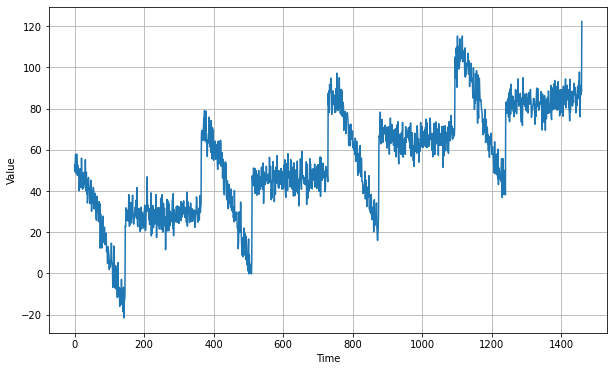

In [10]:
time = np.arange(4 * 365 +1)

slope = 0.05
baseline = 10
amplitude = 40
period = 365

series = baseline + trend(time,slope) + seasonality(time,period,amplitude=amplitude)

noise_level = 5
noise = white_noise(time,noise_level,seed=42)

series += noise

plot_series(time,series)
plt.show()

In [11]:
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

# LSTM RNN Forecasting

In [13]:
%%time

# First a simpler model to get a good training rate
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train,window_size)

model = keras.models.Sequential([
    keras.layers.LSTM(100,return_sequences=True,stateful=True,
                      batch_input_shape=[1,None,1]),
    keras.layers.LSTM(100,return_sequences=True,stateful=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x : x * 200.0)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10 **(epoch/20))

reset_states = ResetStatesCallback()

optimizer = keras.optimizers.SGD(lr = 1e08,momentum=0.9)

model.compile(loss = keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

history = model.fit(train_set,
                    epochs=100,
                    callbacks=[lr_schedule,reset_states])

Epoch 1/100
33/33 [==============================] - 33s 7ms/step - loss: 80.1288 - mae: 80.6288
Epoch 2/100
33/33 [==============================] - 0s 6ms/step - loss: 74.2759 - mae: 74.7759
Epoch 3/100
33/33 [==============================] - 0s 6ms/step - loss: 66.8070 - mae: 67.3070
Epoch 4/100
33/33 [==============================] - 0s 6ms/step - loss: 58.4155 - mae: 58.9155
Epoch 5/100
33/33 [==============================] - 0s 7ms/step - loss: 49.0309 - mae: 49.5309
Epoch 6/100
33/33 [==============================] - 0s 6ms/step - loss: 38.5886 - mae: 39.0882
Epoch 7/100
33/33 [==============================] - 0s 6ms/step - loss: 27.1356 - mae: 27.6339
Epoch 8/100
33/33 [==============================] - 0s 6ms/step - loss: 14.9606 - mae: 15.4570
Epoch 9/100
33/33 [==============================] - 0s 6ms/step - loss: 8.4932 - mae: 8.9789
Epoch 10/100
33/33 [==============================] - 0s 6ms/step - loss: 9.9764 - mae: 10.4675
Epoch 11/100
33/33 [=====================

(1e-08, 0.0001, 0.0, 30.0)

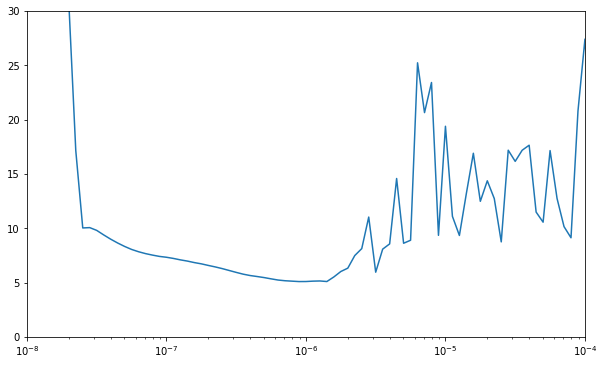

In [14]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [15]:
%%time

# Since we now have the best learning rate lets train our actual model

keras.backend.clear_session()

tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train,window_size)
valid_set = sequential_window_dataset(x_valid,window_size)

model = keras.models.Sequential([
    keras.layers.LSTM(100,return_sequences=True,stateful=True,
                      batch_input_shape=[1,None,1]),
    keras.layers.LSTM(100,return_sequences=True,stateful=True),
    keras.layers.Dense(2),
    keras.layers.Lambda(lambda x : x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=5e-7,momentum=0.9)

model.compile(loss = keras.losses.Huber(),
              optimizer = optimizer,
              metrics=['mae'])

reset_states = ResetStatesCallback()

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5",save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience=50)

model.fit(train_set,
          epochs = 500,
          validation_data = valid_set,
          callbacks = [early_stopping,model_checkpoint,reset_states])

Epoch 1/500
33/33 [==============================] - 3s 35ms/step - loss: 76.3644 - mae: 76.8634 - val_loss: 46.1750 - val_mae: 46.6750
Epoch 2/500
33/33 [==============================] - 0s 10ms/step - loss: 15.7317 - mae: 16.2254 - val_loss: 14.3951 - val_mae: 14.8888
Epoch 3/500
33/33 [==============================] - 0s 10ms/step - loss: 18.6564 - mae: 19.1513 - val_loss: 14.3398 - val_mae: 14.8338
Epoch 4/500
33/33 [==============================] - 0s 10ms/step - loss: 13.9959 - mae: 14.4896 - val_loss: 11.2017 - val_mae: 11.6935
Epoch 5/500
33/33 [==============================] - 0s 10ms/step - loss: 12.3566 - mae: 12.8487 - val_loss: 10.2782 - val_mae: 10.7678
Epoch 6/500
33/33 [==============================] - 0s 10ms/step - loss: 10.6705 - mae: 11.1571 - val_loss: 9.7677 - val_mae: 10.2570
Epoch 7/500
33/33 [==============================] - 0s 10ms/step - loss: 9.4384 - mae: 9.9243 - val_loss: 9.2078 - val_mae: 9.6991
Epoch 8/500
33/33 [==============================] - 

In [16]:
actual_model = keras.models.load_model("my_checkpoint.h5")

In [18]:
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_time - 1:-1, 0]

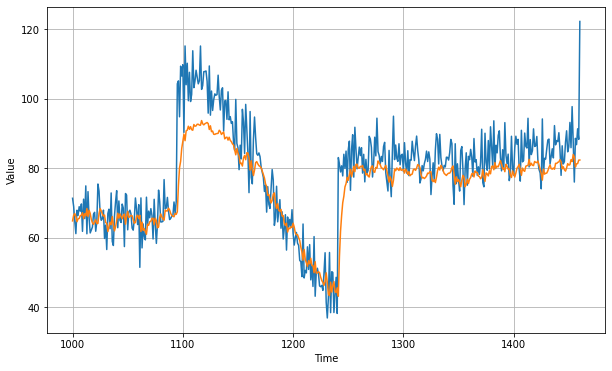

In [22]:
plot_series(time_valid,x_valid)
plot_series(time_valid,rnn_forecast)

In [20]:
keras.metrics.mean_absolute_error(x_valid,rnn_forecast).numpy()

6.1264753